In [1]:
!pip3 install mnist
!pip3 install minisom

# imports
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import numpy as np
import mnist
import scipy.misc
import math

from sklearn import datasets,metrics
from sklearn.datasets import fetch_20newsgroups, fetch_rcv1
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.manifold import TSNE
import umap
from minisom import MiniSom


from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, SpectralClustering


from joblib import Parallel, delayed
from tqdm import tqdm

!pip install ipython-autotime
%load_ext autotime

/home/adalmia1/anaconda3/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


time: 790 µs (started: 2021-01-17 13:33:16 -05:00)


In [2]:
# Load Digits dataset
digits = datasets.load_digits()
digits_n_samples = len(digits.images)
data = digits.images.reshape((digits_n_samples, -1))
digits_X_train, digits_X_test, digits_y_train, digits_y_test = train_test_split(data, digits.target, test_size=0.3, shuffle=True)


# Load full MNIST dataset
MNIST_X_train = mnist.train_images()
MNIST_X_train = MNIST_X_train.reshape((len(MNIST_X_train), -1)) 
MNIST_y_train = mnist.train_labels()

MNIST_X_test = mnist.test_images()
MNIST_X_test = MNIST_X_test.reshape((len(MNIST_X_test), -1)) 
MNIST_y_test = mnist.test_labels()

total_samples = len(MNIST_X_train) + len(MNIST_X_test)
blob_test_size = len(MNIST_X_test)/total_samples

# Load generated blobs dataset

blobs_X, blobs_y = datasets.make_blobs(n_samples=total_samples, centers=10, n_features=MNIST_X_train.shape[1], random_state=0)
blobs_X_train, blobs_X_test, blobs_y_train, blobs_y_test = train_test_split(blobs_X, blobs_y, test_size=blob_test_size, shuffle=True)

# Keep number of training samples consistent
assert (len(blobs_X_train) == len(MNIST_X_train)), print(len(blobs_X_train), len(MNIST_X_train))
assert (len(blobs_X_test) == len(MNIST_X_test)), print(len(blobs_X_test), len(MNIST_X_test))


time: 3.63 s (started: 2021-01-17 13:33:18 -05:00)


In [3]:
# k-Means clustering
def kmeans(X_train, X_test, y_train, y_test, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters, random_state=0)
  y_pred_train = kmeans.fit_predict(X_train)
  train_centers = kmeans.cluster_centers_

  y_pred_test = kmeans.fit_predict(X_test)
  test_centers = kmeans.cluster_centers_

  return y_pred_train, y_pred_test, train_centers, test_centers
  

time: 748 µs (started: 2021-01-17 13:33:22 -05:00)


In [4]:
# Spectral clustering 
def spectral(X_train, X_test, y_train, y_test, n_clusters):
  spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
  y_pred_train = spectral.fit_predict(X_train)
  y_pred_test = spectral.fit_predict(X_test)

  return y_pred_train, y_pred_test


time: 1.09 ms (started: 2021-01-17 13:33:22 -05:00)


In [5]:
def find_permutation(real_labels, labels, n_clusters=10):
    permutation=[]
    for i in range(n_clusters):
        idx = labels == i
        new_label=scipy.stats.mode(real_labels[idx])[0][0]  # Choose the most common label among data points in the cluster
        permutation.append(new_label)
    return permutation

# Evaluation function
def evaluate(X, y, y_pred):
    permutation = find_permutation(y, y_pred)
    #print()
    new_labels = [ permutation[label] for label in y_pred]   # permute the labels
    print("Accurary Score: %0.3f" % metrics.accuracy_score(y, new_labels))
    print("Adjusted Mutual Information Score: %0.3f" % metrics.adjusted_mutual_info_score(y, y_pred))
    print("Adjusted Rand Index Score: %0.3f" % metrics.adjusted_rand_score(y, y_pred))
    print("Normalized Mutual Information Score: %0.3f" % metrics.normalized_mutual_info_score(y, y_pred))

    print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, y_pred))
    print("Completeness: %0.3f" % metrics.completeness_score(y, y_pred))
    print("V-measure: %0.3f" % metrics.v_measure_score(y, y_pred))

    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, y_pred, sample_size=1000))
    print()



time: 1.52 ms (started: 2021-01-17 13:33:22 -05:00)


In [6]:
# dimension reduction

def pca_reduce(X_train, X_test, dim):
  pca = None
  if scipy.sparse.issparse(X_train):
    pca = TruncatedSVD(n_components=dim)
  else:
    pca = PCA(n_components=dim)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.fit_transform(X_test)

  return X_train_pca, X_test_pca


def tsne_reduce(X_train, X_test, dim):
  tsne = TSNE(n_components= dim)
  X_train_tsne = tsne.fit_transform(X_train)
  X_test_tsne = tsne.fit_transform(X_test)

  return X_train_tsne, X_test_tsne

def umap_reduce(X_train, X_test, dim):
  umapr = umap.UMAP(n_components=dim)
  X_train_umap = umapr.fit_transform(X_train)
  X_test_umap = umapr.fit_transform(X_test)
  return X_train_umap, X_test_umap


def kernel_pcarbf_reduce(X_train, X_test, dim):
  kernal_pca = KernelPCA(n_components=dim, kernel='rbf', gamma=2*(1/2610)**2, n_jobs=4)
  print("here")
  X_train_kpca = kernal_pca.fit_transform(X_train)
  print("here")
  X_test_kpca = kernal_pca.fit_transform(X_test)
  return X_train_kpca, X_test_kpca

def kernel_pcapoly_reduce(X_train, X_test, dim):
  kernal_pca = KernelPCA(n_components=dim, kernel='poly', gamma=2*(1/2610)**2)
  X_train_kpca = kernal_pca.fit_transform(X_train)
  X_test_kpca = kernal_pca.fit_transform(X_test)
  return X_train_kpca, X_test_kpca

def kernel_pcasig_reduce(X_train, X_test, dim):
  kernal_pca = KernelPCA(n_components=dim, kernel='sigmoid', gamma=2*(1/2610)**2)
  X_train_kpca = kernal_pca.fit_transform(X_train)
  X_test_kpca = kernal_pca.fit_transform(X_test)
  return X_train_kpca, X_test_kpca

def kernel_pcacos_reduce(X_train, X_test, dim):
  kernal_pca = KernelPCA(n_components=dim, kernel='cosine', gamma=2*(1/2610)**2)
  X_train_kpca = kernal_pca.fit_transform(X_train)
  X_test_kpca = kernal_pca.fit_transform(X_test)
  return X_train_kpca, X_test_kpca




def som_reduce(X_train, X_test, dim):

  grid_size_train = math.ceil(np.sqrt(X_train.shape[0])) 
  
  som = MiniSom(grid_size_train, grid_size_train, X_train.shape[1], sigma=4, learning_rate=0.5, neighborhood_function='triangle')
  som.pca_weights_init(X_train)
  som.train(X_train, 5000, random_order=True, verbose=False)
  X_train_som = np.array(Parallel(n_jobs=-1)(delayed(som.winner)(x) for x in tqdm(X_train))) 
  #X_train_som = np.array([som.winner(x) for x in X_train])


  grid_size_test = math.ceil(np.sqrt(len(X_test)))
  som = MiniSom(grid_size_test, grid_size_test, X_train.shape[1], sigma=4, learning_rate=0.5, neighborhood_function='triangle')
  som.pca_weights_init(X_test)
  som.train(X_test, 5000, random_order=True, verbose=False)
  X_test_som = np.array(Parallel(n_jobs=-1)(delayed(som.winner)(x) for x in tqdm(X_test))) 



  return X_train_som, X_test_som






def dimension_reduce(dimensions, X_train, X_test, y_train, y_test, reduce, n_clusters):
  #y_pred_train, y_pred_test, _, _ = kmeans(X_train, X_test, y_train, y_test, n_clusters)
  #print("Original KMeans")
  #evaluate(X_train,y_train,y_pred_train) 

  #y_pred_train, y_pred_test = spectral(X_train, X_test, y_train, y_test, n_clusters)
  #print("Original Spectral")
  #evaluate(X_train,y_train,y_pred_train) 
  
  
  for dim in dimensions:
    #reduction
    print("Reduce")
    X_train_pca, X_test_pca = reduce(X_train, X_test, dim)
    
    y_pred_train, y_pred_test, _, _ = kmeans(X_train_pca, X_test_pca, y_train, y_test, n_clusters)
    print(X_train_pca.shape)
    print("KMeans dimension reduce: " + str(dim))
    evaluate(X_train_pca,y_train,y_pred_train)

    y_pred_train, y_pred_test= spectral(X_train_pca, X_test_pca, y_train, y_test, n_clusters)
    print("Spectral dimension reduce: " + str(dim))
    evaluate(X_train_pca,y_train,y_pred_train)







time: 3.38 ms (started: 2021-01-17 13:33:22 -05:00)


4
Inversing the points
Plotting


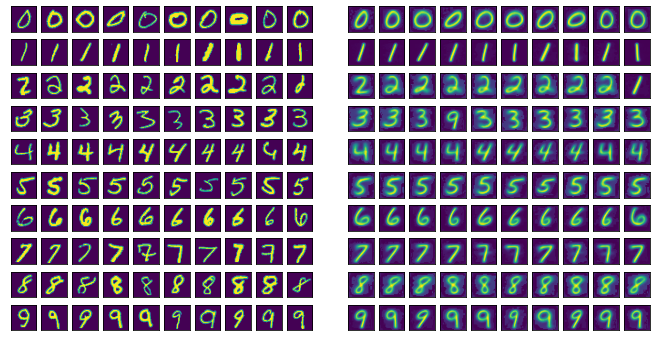

3
Inversing the points
Plotting


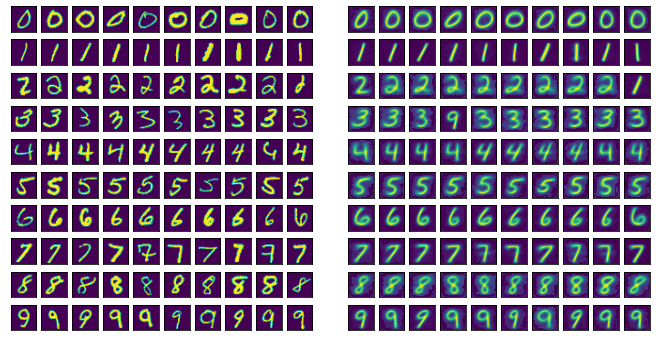

2
Inversing the points
Plotting


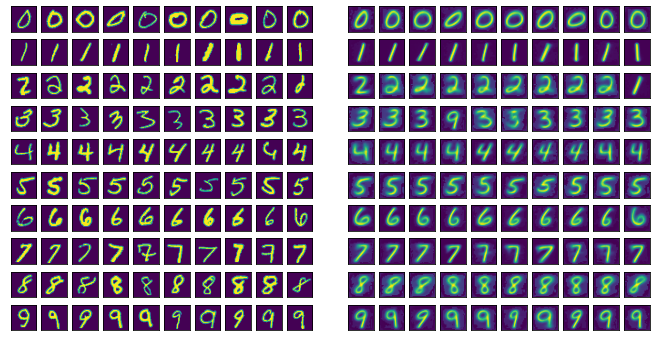

time: 56min 9s (started: 2021-01-17 13:33:32 -05:00)


In [7]:
def umap_inverse_reduce(X_train, X_test, samples, dim):
    umapr = umap.UMAP(n_components=dim, n_jobs=1)
    X_train_umap = umapr.fit_transform(X_train)
    #X_test_umap = umapr.fit_transform(X_test)
    
    print("Inversing the points")
    X_train_inv = umapr.inverse_transform(X_train_umap[np.array(samples).flatten()])
    #X_test_inv = umapr.inverse_transform(X_test_umap)
  
    return X_train_inv, None #X_test_inv


def inverse_dimension_reduce(dimensions, X_train, X_test, y_train, y_test, n_clusters):
    samples = []
    np.random.seed(0)
    for label in range(n_clusters):
        samples.append(np.random.choice(np.where(y_train == label)[0], 10))
    for dim in dimensions:
        print(dim)
        X_train_inv, X_test_inv = umap_inverse_reduce(X_train, X_test, samples, dim)
        print("Plotting")
        plot(X_train, X_train_inv, samples)
      
      
    
    
def plot(X, inv_transformed_X, samples):    
    fig = plt.figure(figsize=(12,6))
    gs = GridSpec(10, 22, fig)
    true_digit_axes = np.zeros((10, 10), dtype=object)
    recreate_digit_axes = np.zeros((10, 10), dtype=object)
    for i in range(10):
        for j in range(10):
            true_digit_axes[i, j] = fig.add_subplot(gs[i, j])
            recreate_digit_axes[i, j] = fig.add_subplot(gs[i, 11 + j])
    
    for i in range(10):
        for j in range(10):
            true_digit_axes[i, j].imshow(X[samples[i][j]].reshape(28, 28))
            true_digit_axes[i, j].set(xticks=[], yticks=[])
            
            recreate_digit_axes[i, j].imshow(inv_transformed_X[i*10+j].reshape(28, 28))
            recreate_digit_axes[i, j].set(xticks=[], yticks=[])
      
    plt.show() 
      
        
inverse_dimension_reduce([4, 3, 2], MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test, 10)

In [ ]:
# Visualization general

def visualize(X_train, X_test, y_train, y_test, reduce, title, n_clusters):

  X_train_r, X_test_r = reduce(X_train, X_test, 2)


  kmy_pred_train, kmy_pred_test, train_centers, test_centers = kmeans(X_train_r, X_test_r, y_train, y_test, n_clusters)
  spy_pred_train, spy_pred_test = spectral(X_train_r, X_test_r, y_train, y_test, n_clusters)

  
  fig=plt.figure(figsize=(14,10))
  # Train orginial labels
  plt.subplot(2, 3, 1)
  plt.gca().set_title('Train Data With Orginial Labels')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= y_train, s=50, cmap='Set3')

  # Train kmeans labels
  plt.subplot(2, 3, 2)
  plt.gca().set_title('Train Data With KMeans Clusters')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= kmy_pred_train, s=50, cmap='Set3')
  plt.scatter(train_centers [:, 0], train_centers [:, 1], c='black', s=200, alpha=0.8)

  # Train spectral labels
  plt.subplot(2, 3, 3)
  plt.gca().set_title('Train Data With Spectral Clusters')
  plt.scatter(X_train_r[:, 0], X_train_r[:, 1], c= spy_pred_train, s=50, cmap='Set3')


  # Test orginial labels
  plt.subplot(2, 3, 4)
  plt.gca().set_title('Test Data With Orginial Labels')
  plt.scatter(X_test_r[:, 0], X_test_r[:, 1], c= y_test, s=50, cmap='Set3')

  # Test kmeans labels
  plt.subplot(2, 3, 5)
  plt.gca().set_title('Test Data With KMeans Clusters')
  plt.scatter(X_test_r[:, 0], X_test_r[:, 1], c= kmy_pred_test, s=50, cmap='Set3')
  plt.scatter(test_centers[:, 0], test_centers[:, 1], c='black', s=200, alpha=0.8)

  # Test spectral labels
  plt.subplot(2, 3, 6)
  plt.gca().set_title('Test Data With Spectral Clusters')
  plt.scatter(X_test_r[:, 0], X_test_r[:, 1], c= spy_pred_test, s=50, cmap='Set3')

  fig.suptitle(title + " Reduction", fontsize=16)

  fig.tight_layout()
  fig.subplots_adjust(top=0.93)
  plt.show()



In [8]:
# Digits reduction 
dimension_reduce([700, 600, 500, 400, 300, 200, 100, 50], MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test, umap_reduce, 10)
#visualize(digits_X_train, digits_X_test, digits_y_train, digits_y_test, som_reduce, "SOM", 10)

#visualize(digits_X_train, digits_X_test, digits_y_train, digits_y_test, tsne_reduce, "TSNE", 10)

Reduce
here2
(60000, 700)
KMeans dimension reduce: 700
Accurary Score: 0.859
Purity Score: 0.859
Adjusted Mutual Information Score: 0.841
Adjusted Rand Index Score: 0.761
Normalized Mutual Information Score: 0.841
Homogeneity: 0.831
Completeness: 0.851
V-measure: 0.841
Silhouette Coefficient: 0.616



/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Spectral dimension reduce: 700
Accurary Score: 0.675
Purity Score: 0.675
Adjusted Mutual Information Score: 0.789
Adjusted Rand Index Score: 0.595
Normalized Mutual Information Score: 0.790
Homogeneity: 0.707
Completeness: 0.894
V-measure: 0.790
Silhouette Coefficient: 0.282

Reduce
here2
(60000, 600)
KMeans dimension reduce: 600
Accurary Score: 0.861
Purity Score: 0.861
Adjusted Mutual Information Score: 0.842
Adjusted Rand Index Score: 0.763
Normalized Mutual Information Score: 0.842
Homogeneity: 0.833
Completeness: 0.852
V-measure: 0.842
Silhouette Coefficient: 0.619



/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Spectral dimension reduce: 600
Accurary Score: 0.634
Purity Score: 0.634
Adjusted Mutual Information Score: 0.715
Adjusted Rand Index Score: 0.413
Normalized Mutual Information Score: 0.715
Homogeneity: 0.616
Completeness: 0.853
V-measure: 0.715
Silhouette Coefficient: 0.232

Reduce
here2
(60000, 500)
KMeans dimension reduce: 500
Accurary Score: 0.859
Purity Score: 0.859
Adjusted Mutual Information Score: 0.842
Adjusted Rand Index Score: 0.762
Normalized Mutual Information Score: 0.842
Homogeneity: 0.832
Completeness: 0.852
V-measure: 0.842
Silhouette Coefficient: 0.614



/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Spectral dimension reduce: 500
Accurary Score: 0.692
Purity Score: 0.692
Adjusted Mutual Information Score: 0.743
Adjusted Rand Index Score: 0.477
Normalized Mutual Information Score: 0.743
Homogeneity: 0.667
Completeness: 0.838
V-measure: 0.743
Silhouette Coefficient: 0.288

Reduce
here2
(60000, 400)
KMeans dimension reduce: 400
Accurary Score: 0.860
Purity Score: 0.860
Adjusted Mutual Information Score: 0.841
Adjusted Rand Index Score: 0.762
Normalized Mutual Information Score: 0.841
Homogeneity: 0.832
Completeness: 0.851
V-measure: 0.841
Silhouette Coefficient: 0.612



/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Spectral dimension reduce: 400
Accurary Score: 0.773
Purity Score: 0.773
Adjusted Mutual Information Score: 0.847
Adjusted Rand Index Score: 0.742
Normalized Mutual Information Score: 0.847
Homogeneity: 0.795
Completeness: 0.906
V-measure: 0.847
Silhouette Coefficient: 0.386

Reduce
here2
(60000, 300)
KMeans dimension reduce: 300
Accurary Score: 0.860
Purity Score: 0.860
Adjusted Mutual Information Score: 0.841
Adjusted Rand Index Score: 0.761
Normalized Mutual Information Score: 0.841
Homogeneity: 0.831
Completeness: 0.851
V-measure: 0.841
Silhouette Coefficient: 0.619



/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Spectral dimension reduce: 300
Accurary Score: 0.640
Purity Score: 0.640
Adjusted Mutual Information Score: 0.722
Adjusted Rand Index Score: 0.437
Normalized Mutual Information Score: 0.722
Homogeneity: 0.653
Completeness: 0.808
V-measure: 0.722
Silhouette Coefficient: 0.285

Reduce
here2
(60000, 200)
KMeans dimension reduce: 200
Accurary Score: 0.858
Purity Score: 0.858
Adjusted Mutual Information Score: 0.839
Adjusted Rand Index Score: 0.758
Normalized Mutual Information Score: 0.839
Homogeneity: 0.830
Completeness: 0.849
V-measure: 0.839
Silhouette Coefficient: 0.619



/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Spectral dimension reduce: 200
Accurary Score: 0.665
Purity Score: 0.665
Adjusted Mutual Information Score: 0.766
Adjusted Rand Index Score: 0.590
Normalized Mutual Information Score: 0.766
Homogeneity: 0.703
Completeness: 0.841
V-measure: 0.766
Silhouette Coefficient: 0.268

Reduce
here2
(60000, 100)
KMeans dimension reduce: 100
Accurary Score: 0.860
Purity Score: 0.860
Adjusted Mutual Information Score: 0.841
Adjusted Rand Index Score: 0.760
Normalized Mutual Information Score: 0.841
Homogeneity: 0.831
Completeness: 0.850
V-measure: 0.841
Silhouette Coefficient: 0.614



/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Spectral dimension reduce: 100
Accurary Score: 0.606
Purity Score: 0.606
Adjusted Mutual Information Score: 0.649
Adjusted Rand Index Score: 0.326
Normalized Mutual Information Score: 0.650
Homogeneity: 0.564
Completeness: 0.766
V-measure: 0.650
Silhouette Coefficient: 0.171

Reduce
here2
(60000, 50)
KMeans dimension reduce: 50
Accurary Score: 0.858
Purity Score: 0.858
Adjusted Mutual Information Score: 0.839
Adjusted Rand Index Score: 0.758
Normalized Mutual Information Score: 0.839
Homogeneity: 0.830
Completeness: 0.849
V-measure: 0.839
Silhouette Coefficient: 0.624



/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/adalmia1/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Spectral dimension reduce: 50
Accurary Score: 0.638
Purity Score: 0.638
Adjusted Mutual Information Score: 0.720
Adjusted Rand Index Score: 0.434
Normalized Mutual Information Score: 0.720
Homogeneity: 0.650
Completeness: 0.806
V-measure: 0.720
Silhouette Coefficient: 0.260

time: 2h 38min 56s (started: 2021-01-16 11:58:57 -05:00)


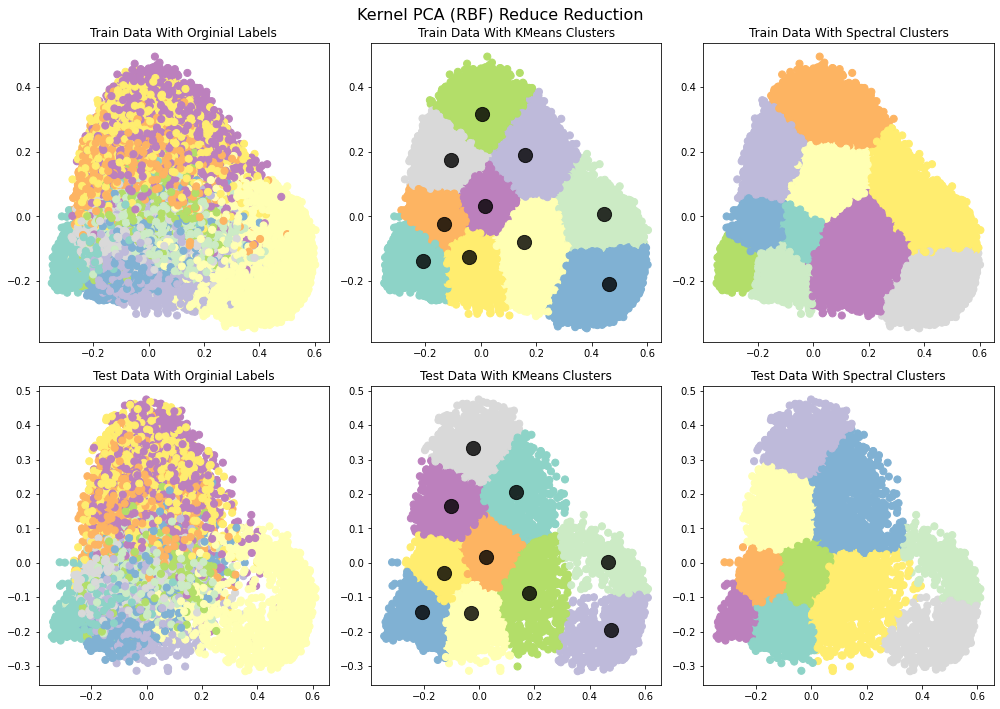

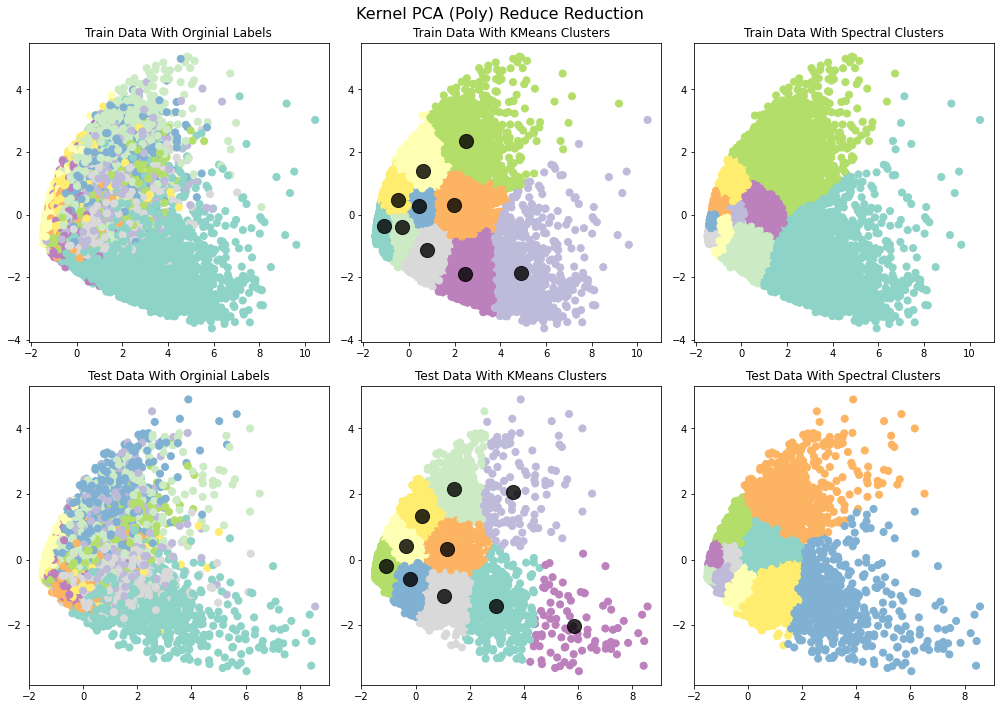

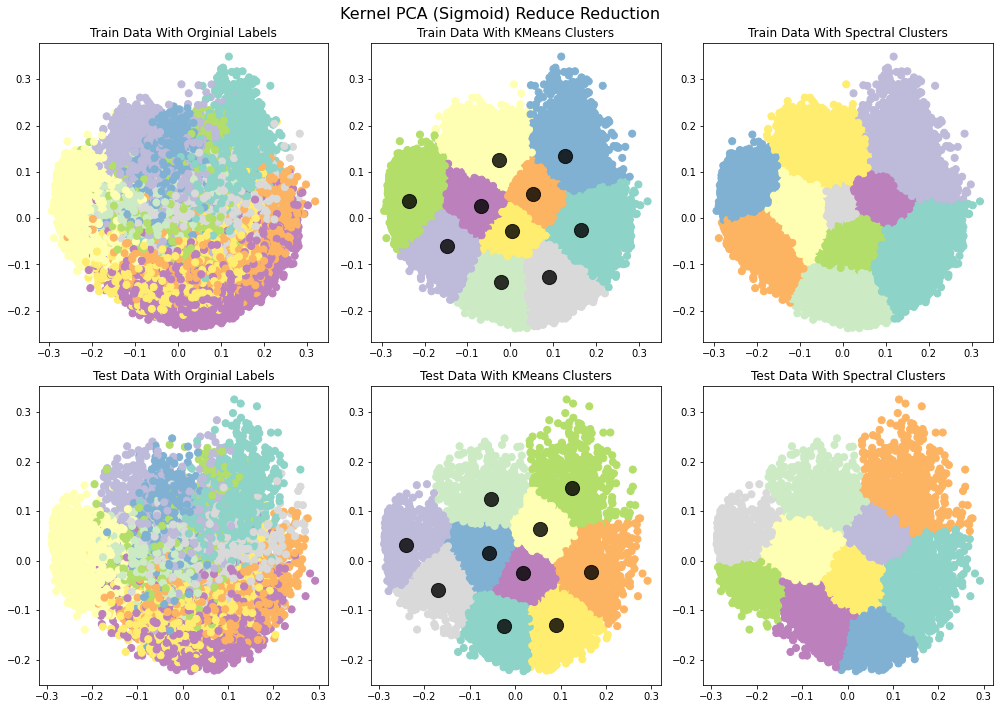

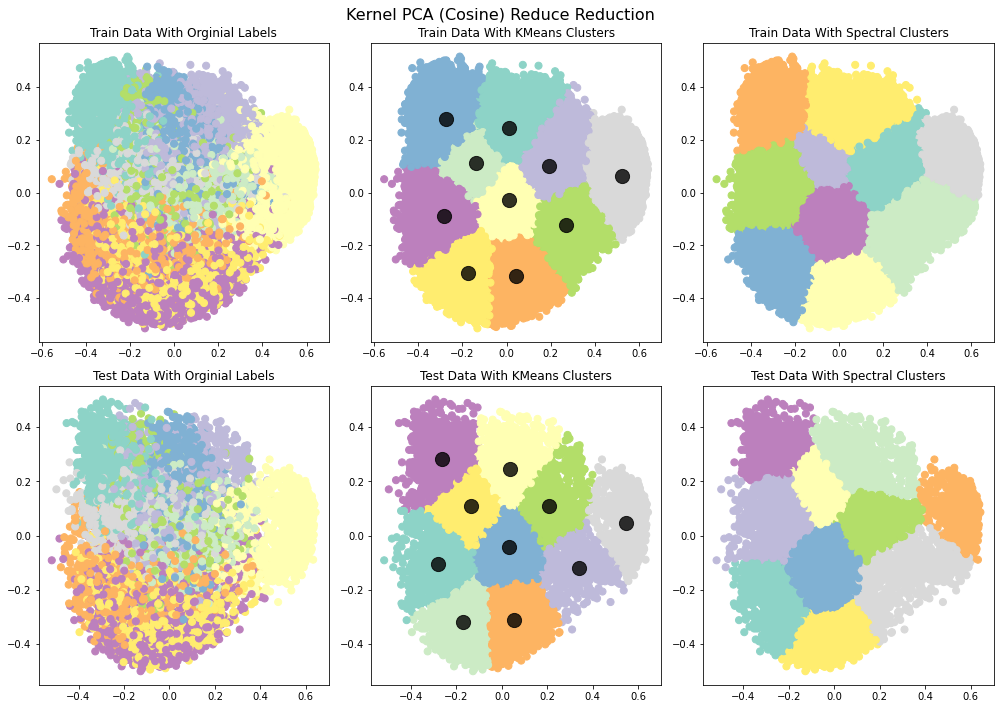

time: 31min 54s (started: 2021-01-15 16:39:08 -05:00)


In [9]:
# MNIST reduction 

#dimension_reduce([700, 600, 500, 400, 300, 200, 100, 50], MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test,umap_reduce, 10)
#dimension_reduce([700, 600, 500, 400, 300, 200, 100, 50], MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test,kernel_pcarbf_reduce, 10)


#visualize(MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test, som_reduce, "UMAP Reduce", 10)
visualize(MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test, kernel_pcarbf_reduce, "Kernel PCA (RBF) Reduce", 10)
visualize(MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test, kernel_pcapoly_reduce, "Kernel PCA (Poly) Reduce", 10)
visualize(MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test, kernel_pcasig_reduce, "Kernel PCA (Sigmoid) Reduce", 10)
visualize(MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test, kernel_pcacos_reduce, "Kernel PCA (Cosine) Reduce", 10)

#dimension_reduce([750, 700, 600, 500, 400, 300, 200, 100, 50], MNIST_X_train, MNIST_X_test, MNIST_y_train, MNIST_y_test, umap_reduce, 10)



In [ ]:
# blobs reduction 
dimension_reduce([700, 600, 500, 400, 300, 200, 100, 50, 4], blobs_X_train, blobs_X_test, blobs_y_train, blobs_y_test, 10)
#visualize_pca(blobs_X_train, blobs_X_test, blobs_y_train, blobs_y_test, 10)
#visualize_tsne(blobs_X_train, blobs_X_test, blobs_y_train, blobs_y_test, 10)

In [ ]:
# fetch 20 reduction 
#dimension_reduce([ 1000, 500, 300, 200, 100, 50, 20], newsgroups_X_train , newsgroups_X_test , newsgroups_y_train , newsgroups_y_test, 20)

#PCA

visualize(newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, pca_reduce, "PCA", 20)

#Kernel
visualize(newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, kernel_pcarbf_reduce, "Kernel PCA (RBF) Reduce", 20)
visualize(newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, kernel_pcacos_reduce, "Kernel PCA (Cosine) Reduce", 20)
visualize(newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, kernel_pcasig_reduce, "Kernel PCA (Sigmoid) Reduce", 20)
visualize(newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, kernel_pcapoly_reduce, "Kernel PCA (Poly) Reduce", 20)


#SOM
visualize(newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, som_reduce, "SOM Reduce", 20)

#TSNE
visualize(newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, tsne_reduce, "TSNE Reduce", 20)

#UMAP
visualize(newsgroups_X_train , newsgroups_X_test , newsgroups_y_train, newsgroups_y_test, umap_reduce, "UMAP Reduce", 20)



In [ ]:
# rcv1 reduction
dimension_reduce([ 1000, 500, 300, 200, 100, 50, 20], rcv1_X_train , rcv1_X_test , rcv1_y_train , rcv1_y_test, 103)
visualize_pca(rcv1_X_train , rcv1_X_test , rcv1_y_train , rcv1_y_test, 103)
visualize_tsne(rcv1_X_train , rcv1_X_test , rcv1_y_train , rcv1_y_test, 103, True)